<a href="https://www.kaggle.com/code/salilapte/image-caption-cnn-generator?scriptVersionId=229773821" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/17, Loss: 4.0308
Epoch 2/17, Loss: 3.3826
Epoch 3/17, Loss: 3.1754
Epoch 4/17, Loss: 3.0680
Epoch 5/17, Loss: 2.9682
Epoch 6/17, Loss: 2.9241
Epoch 7/17, Loss: 2.8482
Epoch 8/17, Loss: 2.8270
Epoch 9/17, Loss: 2.7969
Epoch 10/17, Loss: 2.8031
Epoch 11/17, Loss: 2.7355
Epoch 12/17, Loss: 2.7211
Epoch 13/17, Loss: 2.7269
Epoch 14/17, Loss: 2.7013
Epoch 15/17, Loss: 2.6884
Epoch 16/17, Loss: 2.7122
Epoch 17/17, Loss: 2.6651


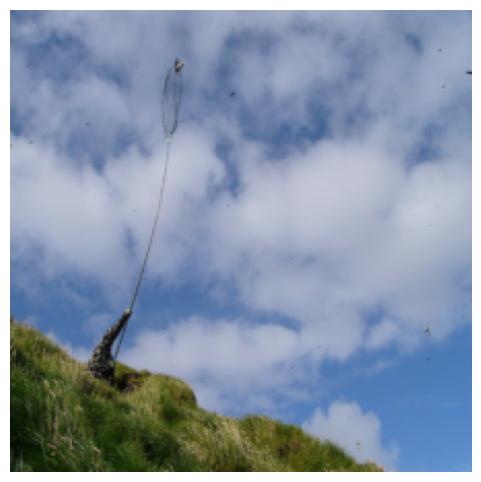

Generated Caption: a person jumps up into the air to catch a grassy hill .

Actual Caption: A man wearing camouflage holds a net on a very long handle into the air .

Similarity Score: 0.1604



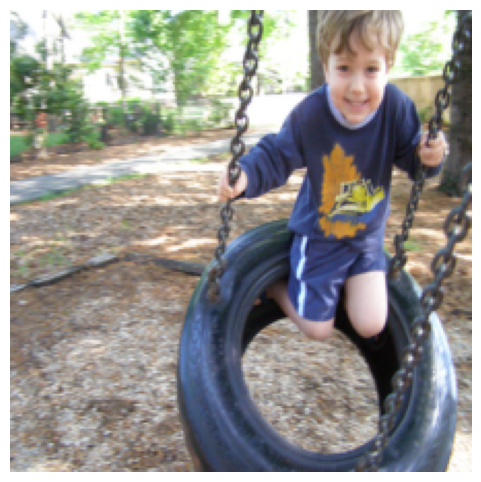

Generated Caption: a little boy is running on the top of a picture with a tire tire

Actual Caption: Young boy swinging on a tire swing .

Similarity Score: 0.2867



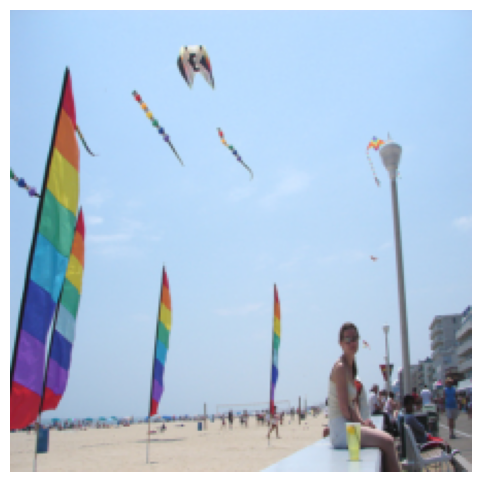

Generated Caption: a young boy in a sandy area in hand for a water that says with

Actual Caption: A girl on a beach with rainbow flags .

Similarity Score: 0.0587



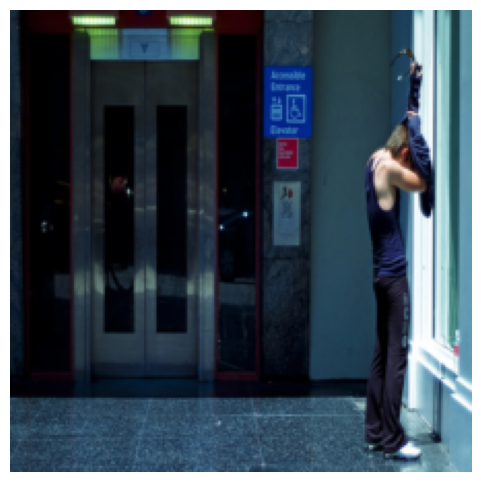

Generated Caption: two people are walking down a street .

Actual Caption: A man puts his shirt on near an elevator .

Similarity Score: 0.0000



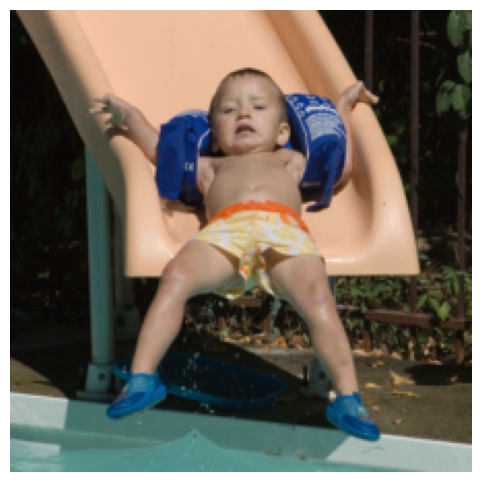

Generated Caption: a girl wearing a dress walking onto the busy yard .

Actual Caption: A baby boy wearing a shoulder life saver is at the very edge of an orange pool slide .

Similarity Score: 0.0987



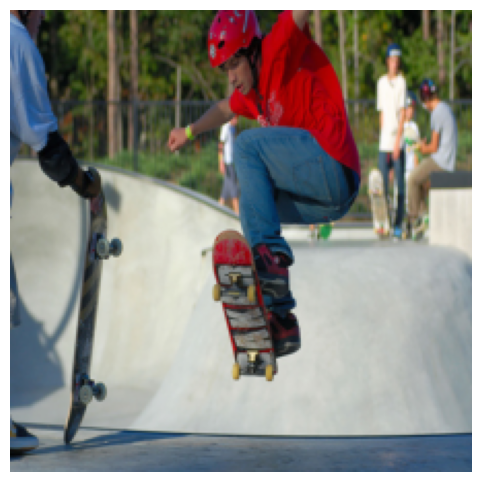

Generated Caption: guys playing front of people are <UNK> .

Actual Caption: A man wearing a red helmet jumps up while riding a skateboard .

Similarity Score: 0.0000



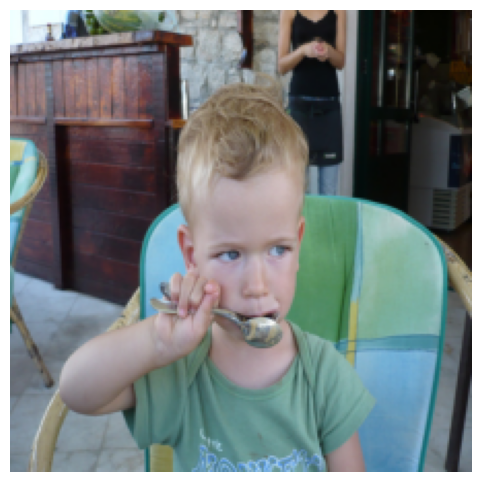

Generated Caption: a man with a <UNK> paper while two baby is sitting on a big to

Actual Caption: A small child dressed in green is eating with a spoon .

Similarity Score: 0.1078



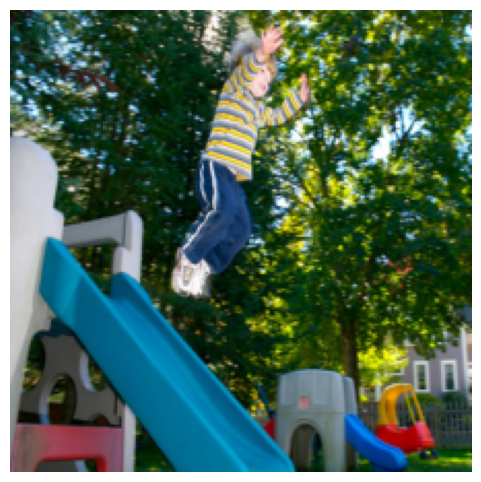

Generated Caption: a boy catches a frisbee .

Actual Caption: A little boy in a striped shirt jumps from a blue slide .

Similarity Score: 0.1096



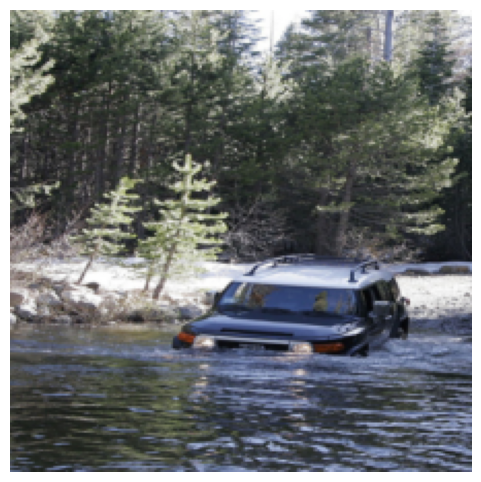

Generated Caption: a man is <UNK> under a lake .

Actual Caption: A car is sinking underwater in a lake or river .

Similarity Score: 0.1909



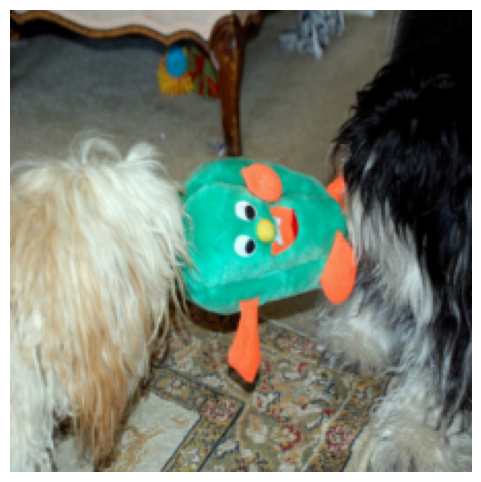

Generated Caption: two brown dogs play while bite each a green and playing a rope toy together

Actual Caption: Two dogs fight over a green stuffed toy .

Similarity Score: 0.2721



In [7]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
nltk.download('punkt')

# ----------------------------
# 1. Device Configuration
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# 2. CNN Feature Extractor (ResNet50)
# ----------------------------
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # remove final FC layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, 512)

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)  # [B, 2048, 1, 1]
            features = features.view(features.size(0), -1)
        return self.fc(features)

# ----------------------------
# 3. Transformer Decoder for Captioning
# ----------------------------
class CaptionGenerator(nn.Module):
    def __init__(self, feature_size=512, hidden_size=512, vocab_size=2002, num_layers=2, num_heads=8):
        super(CaptionGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 50, hidden_size))
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads), num_layers
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        captions = torch.clamp(captions, min=0, max=2001)
        captions = self.embedding(captions) + self.pos_encoder[:, :captions.size(1), :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(captions.device)
        output = self.transformer_decoder(captions.permute(1, 0, 2), features.unsqueeze(0), tgt_mask).permute(1, 0, 2)
        return self.fc(output)

# ----------------------------
# 4. Flickr8k Dataset
# ----------------------------
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.captions_df = pd.read_csv(captions_file)
        self.image_files = list(self.captions_df['image'].unique())[:4000]
        self.captions = {img: self.captions_df[self.captions_df['image'] == img]['caption'].tolist() for img in self.image_files}

        all_tokens = [word_tokenize(c.lower()) for captions in self.captions.values() for c in captions]
        word_counts = Counter([word for caption in all_tokens for word in caption])
        self.vocab = {word: i + 4 for i, (word, _) in enumerate(word_counts.most_common(2000))}
        self.vocab["<UNK>"] = 1
        self.vocab["<PAD>"] = 0
        self.vocab["<SOS>"] = 2
        self.vocab["<EOS>"] = 3
        self.idx_to_word = {idx: word for word, idx in self.vocab.items()}

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        actual_captions = self.captions[self.image_files[idx]]
        if self.transform:
            image = self.transform(image)
        return image, actual_captions

    def __len__(self):
        return len(self.image_files)

# ----------------------------
# 5. Collate Function
# ----------------------------
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, captions

# ----------------------------
# 6. Load Dataset and Initialize
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_dir = "/kaggle/input/flickr8k/Images"
captions_file = "/kaggle/input/flickr8k/captions.txt"
dataset = torch.utils.data.Subset(Flickr8kDataset(image_dir, captions_file, transform=transform), range(2000))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# ----------------------------
# 7. Training Setup
# ----------------------------
feature_extractor = CNNFeatureExtractor().to(device)
vocab_size = len(dataset.dataset.vocab)
caption_model = CaptionGenerator(vocab_size=vocab_size).to(device)
optimizer = optim.Adam(caption_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# ----------------------------
# 8. Training Loop
# ----------------------------
epochs = 17
caption_model.train()
for epoch in range(epochs):
    total_loss = 0
    for images, actual_captions in dataloader:
        images = images.to(device)
        features = feature_extractor(images)

        tokenized_captions = []
        for caps in actual_captions:
            selected_caption = random.choice(caps)
            tokens = [dataset.dataset.vocab.get(word, 1) for word in word_tokenize(selected_caption.lower())[:20]]
            tokens = [2] + tokens + [3]  # <SOS> and <EOS>
            tokenized_captions.append(torch.tensor(tokens, device=device))

        padded = nn.utils.rnn.pad_sequence(tokenized_captions, batch_first=True, padding_value=0)
        inputs = padded[:, :-1]
        targets = padded[:, 1:]

        optimizer.zero_grad()
        output = caption_model(features, inputs)
        loss = criterion(output.view(-1, output.shape[-1]), targets.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# ----------------------------
# 9. Inference
# ----------------------------
caption_model.eval()
feature_extractor.eval()

vectorizer = TfidfVectorizer()
selected_indices = random.sample(range(len(dataset)), 10)
selected_images = [dataset[i] for i in selected_indices]

for image, actual_captions in selected_images:
    image_tensor = image.unsqueeze(0).to(device)
    features = feature_extractor(image_tensor)

    caption = [2]  # <SOS>
    for _ in range(15):
        input_seq = torch.tensor(caption, device=device).unsqueeze(0)
        output = caption_model(features, input_seq)
        probs = torch.softmax(output[:, -1, :], dim=-1).squeeze(0)
        next_word = torch.multinomial(probs, 1).item()
        if next_word == 3:  # <EOS>
            break
        caption.append(next_word)

    generated_caption = " ".join([dataset.dataset.idx_to_word.get(idx, "<UNK>") for idx in caption[1:]])
    actual_caption_text = random.choice(actual_captions)

    tfidf_matrix = vectorizer.fit_transform([generated_caption, actual_caption_text])
    similarity_score = (tfidf_matrix * tfidf_matrix.T).toarray()[0, 1]

    plt.figure(figsize=(6, 6))
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()
    print(f"Generated Caption: {generated_caption}\n")
    print(f"Actual Caption: {actual_caption_text}\n")
    print(f"Similarity Score: {similarity_score:.4f}\n")